In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
# path to working directory
master_path = "/content/gdrive/My Drive/Colab Notebooks/master/"
os.environ['PYTHONPATH'] += ":" + master_path

In [4]:
# change working directory
%cd /content/gdrive/My Drive/Colab Notebooks/master/

/content/gdrive/My Drive/Colab Notebooks/master


In [5]:
! sudo apt-get update
! sudo apt-get install tesseract-ocr
! sudo apt-get install libtesseract-dev

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Hit:2 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:6 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:11 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Hit:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
tessera

In [6]:
!pip install -r requirements.txt

     |████████████████████████████████| 1.2MB 2.6MB/s 
     |████████████████████████████████| 829kB 8.2MB/s 
     |████████████████████████████████| 92kB 7.9MB/s 
     |████████████████████████████████| 81kB 8.0MB/s 
     |████████████████████████████████| 122kB 14.2MB/s 
     |████████████████████████████████| 788kB 9.6MB/s 
     |████████████████████████████████| 61kB 7.5MB/s 
     |████████████████████████████████| 112kB 18.4MB/s 
     |████████████████████████████████| 153kB 16.7MB/s 
     |████████████████████████████████| 1.4MB 15.9MB/s 
     |████████████████████████████████| 9.7MB 28.4MB/s 
     |████████████████████████████████| 28.2MB 102kB/s 
     |████████████████████████████████| 2.1MB 47.2MB/s 
     |████████████████████████████████| 122kB 37.8MB/s 
     |████████████████████████████████| 71kB 9.5MB/s 
     |████████████████████████████████| 358kB 39.2MB/s 
     |████████████████████████████████| 1.3MB 36.8MB/s 
     |████████████████████████████████| 133kB 43.8MB/s 
   

In [1]:
# change working directory
%cd /content/gdrive/My Drive/Colab Notebooks/master/

/content/gdrive/My Drive/Colab Notebooks/master


In [0]:
import os
import numpy as np
import cv2

import requests
import pytesseract
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook

def plot(img, cmap=None):
    plt.rcParams['figure.figsize'] = (15, 15)
    plt.imshow(img, cmap)

### Read images

In [3]:
all_imgs = [i for i in os.listdir('samples/') if i.endswith('.jpg')]
print(f'{len(all_imgs)} images in folder')
# plot(all_imgs[4])

172 images in folder


### Request to human detector

In [4]:
from src.human_detector_service.tensorflow_human_detection import DetectorAPI
from src.contour import Contour

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [6]:
model_path = 'src/human_detector_service/model/faster_rcnn_inception_v2_coco_2018_01_28/frozen_inference_graph.pb'
odapi = DetectorAPI(path_to_ckpt=model_path)
# threshold = 0.7

def detect_human(src_img, threshold = 0.95):
    shape = src_img.shape[1], src_img.shape[0]
    img = cv2.resize(src_img, (1280, 720))

    boxes, scores, classes, num = odapi.processFrame(src_img)
    boxes = [box for box, scores, _ in zip(boxes, scores, classes) if scores > threshold]
    # Visualization of the results of a detection.

    humans = []
    for cnt in boxes:
        y_l = cnt[0]
        x_l = cnt[1]
        y_r, x_r = cnt[2:]

        cropped_human = n_img[y_l: y_r, x_l: x_r]
        humans.append(cropped_human)

    print(f'\nDetected {len(humans)} humans in {name} image')
    return humans


Elapsed Time: 5.348354816436768

Detected 5 humans in article_big_174101436184282.jpg image


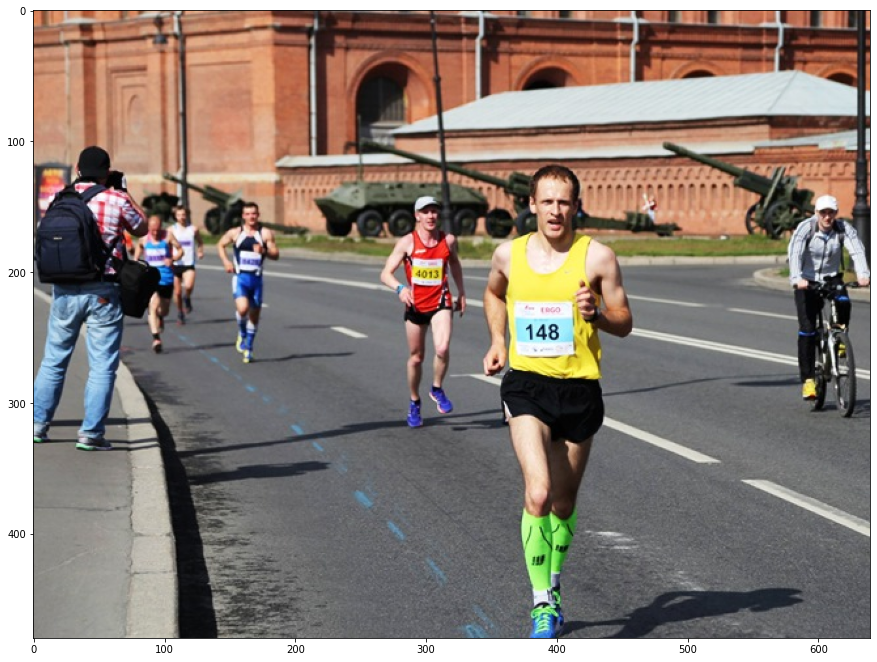

In [7]:
name = all_imgs[3]
img = open(f'samples/{name}', 'rb').read()
n_img = cv2.cvtColor(cv2.imread(f'samples/{name}'), cv2.COLOR_BGR2RGB)
plot(n_img)

humans = detect_human(n_img)

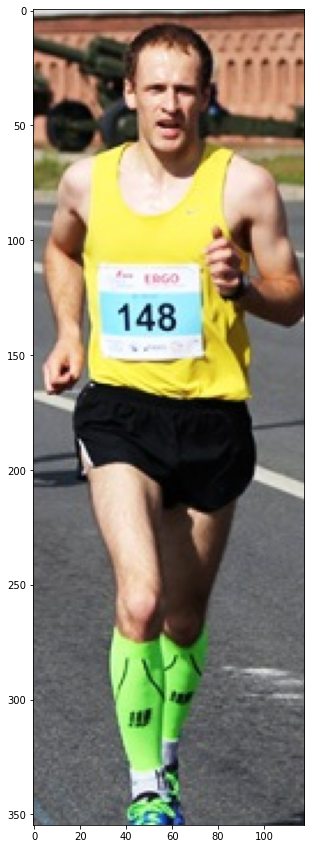

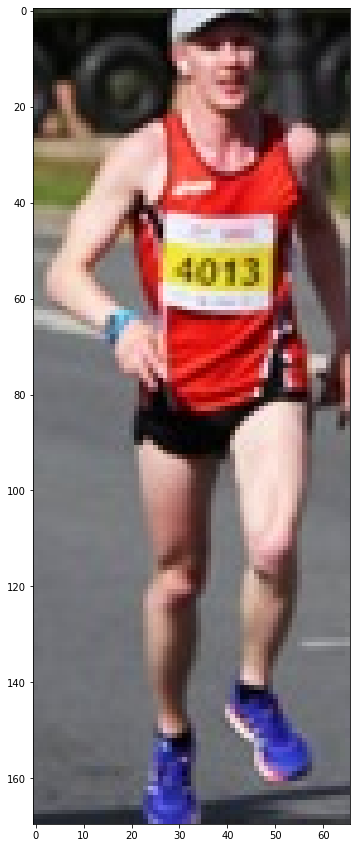

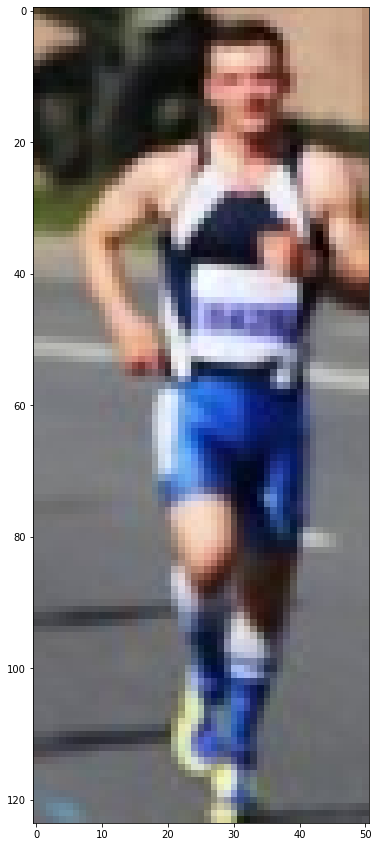

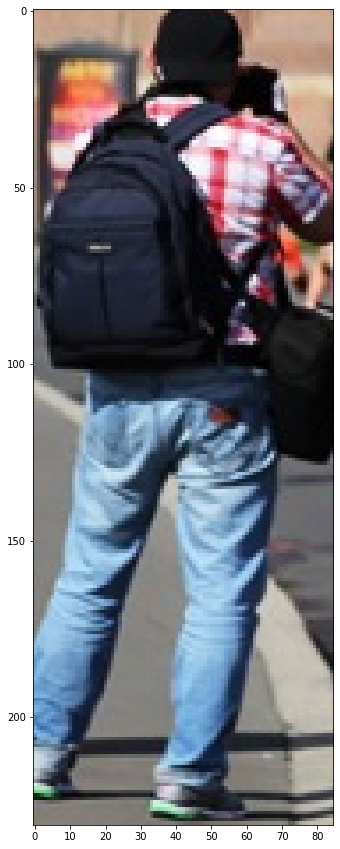

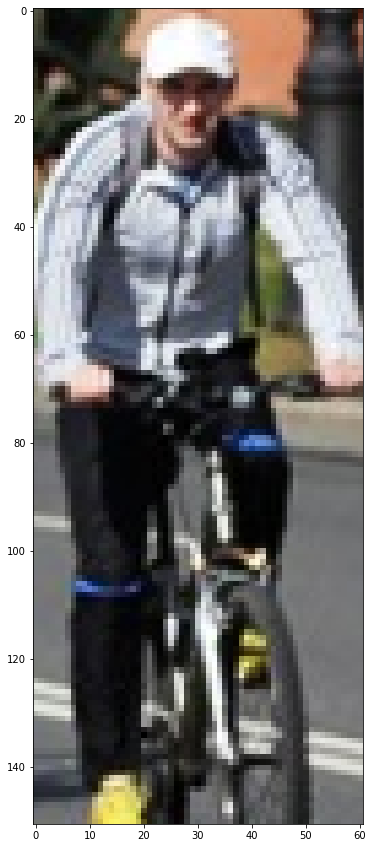

<Figure size 1080x1080 with 0 Axes>

In [8]:
# check humans
for i in humans:
    plot(i)
    plt.figure()

### Detect text on humans

In [9]:
from src.text_detector.text_detector import detect, crop

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth



Loading model and optimizer from checkpoint 'src/text_detector/Detection/PSEnet/models/PSEnet_best.pth.tar.part'
Loaded checkpoint 'src/text_detector/Detection/PSEnet/models/PSEnet_best.pth.tar.part' (epoch 6)


In [10]:
boxed = []
text_save_path = 'src/text_recognition/cropped_text_baseline/'
!rm -rf {text_save_path}
!mkdir {text_save_path}

human_counter = 0
for test in tqdm_notebook(humans):
    h, w, c = test.shape
    boxes, text_on = detect(test.copy())
    # get detected text from humans
    for i, box in enumerate(boxes):
        cropped_text = crop(test.copy(), box)
        try:
            cv2.imwrite(f'{text_save_path}{human_counter}_{i}_{name}', cropped_text)
        except:
            print(f'Trouble with image {human_counter}_{i}_{name}')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2796: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


### REcognize text

In [0]:
output = !python3 src/text_recognition.py \
--image_folder {text_save_path}

In [13]:
from IPython.core.display import display, HTML
from PIL import Image
import base64
import io
import pandas as pd

def postprocessing(text) -> str:
    changed_text = text
    changed_text = [str(s) for s in changed_text if s.isdigit()]
    if len(changed_text) > 1:
        return ''.join(changed_text)
    else:
        return False

data = pd.DataFrame()
for ind, row in enumerate(output[output.index('image_path               \tpredicted_labels         \tconfidence score')+2:]):
    row = row.split('\t')
    filename = row[0].strip()
    label = row[1].strip()
#     label = postprocessing(label)
    conf = row[2].strip()
#     if float(conf) > 0.7 and label:
    img = Image.open(filename)
    img_buffer = io.BytesIO()
    img.save(img_buffer, format="PNG")
    imgStr = base64.b64encode(img_buffer.getvalue()).decode("utf-8") 

    data.loc[ind, 'img'] = '<img src="data:image/png;base64,{0:s}">'.format(imgStr)
    data.loc[ind, 'id'] = filename
    data.loc[ind, 'label'] = label
    data.loc[ind, 'conf'] = conf

html_all = data.to_html(escape=False)
display(HTML(html_all))